In [71]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

sea.set()
sea.set_style("white")

# Create a connection to the weather database.
connection = sqlite3.connect("SEA_weather.db")
cursor = connection.cursor()

### Time of Max Temperature
A frequent observation of someone close to me who is from Taiwan is how *odd* it is that the hottest part of the day in Seattle seems to occur in the late afternoon. In Taiwan, the hottest part of the day consistantly occurs at noon. As a Seattle native, I'd accepted this as natural, but became interested in supporting these observations.

I first started by ranking each entry in the database by temperature for that day. Entries that have a rank of 1 have the maximum temperature for that day.

In [70]:
query = """
    SELECT DATE(DateTime) as Date, TIME(DateTime) as Time, Temperature, RANK() OVER (PARTITION BY DATE(DateTime) ORDER BY Temperature DESC) as Rank
    FROM SEA_weather
"""

max_temps = pd.read_sql_query(query, connection)
display(max_temps)

,Date,Time,Temperature,Rank
0,2010-01-01,09:53:00,51,1
1,2010-01-01,12:53:00,51,1
2,2010-01-01,13:53:00,51,1
3,2010-01-01,14:53:00,51,1
4,2010-01-01,07:53:00,50,5
...,...,...,...,...
151488,2023-12-31,20:53:00,42,19
151489,2023-12-31,23:53:00,42,19
151490,2023-12-31,02:33:00,41,27
151491,2023-12-31,05:53:00,40,28


As we can see from the header, however, some maximum temperatures are reached multiple times a day. For this exploration, I decided to consider the _average_ time for the maximum temperature. First we select all entries that had a rank of 1 (maximum temperature) grouped by the day. Then I needed to convert each time measurement to seconds from midnight, average them, and then transform back into a time. This gave us the average time of the maximum temperature for each day.

In [73]:
query = """
    WITH RankedTemp AS (
            SELECT DATE(DateTime) as Date, TIME(DateTime) as Time, Temperature, RANK() OVER (PARTITION BY DATE(DateTime) ORDER BY Temperature DESC) as Rank
            FROM SEA_weather
    )
    SELECT Date, TIME(AVG((STRFTIME('%H', Time) * 60 + STRFTIME('%M', Time)) * 60), 'unixepoch') AS AvgTime
    FROM RankedTemp
    WHERE Rank = 1
    GROUP BY Date
"""

max_temps = pd.read_sql_query(query, connection)
display(max_temps)

,Date,AvgTime
0,2010-01-01,12:53:00
1,2010-01-02,09:53:00
2,2010-01-03,15:53:00
3,2010-01-04,16:54:00
4,2010-01-05,04:53:00
...,...,...
5107,2023-12-27,10:53:00
5108,2023-12-28,15:53:00
5109,2023-12-29,15:53:00
5110,2023-12-30,04:53:00


I wanted to see a frequency plot of the time of average maximum temperature based on the hour. To do this, I grouped the entries by the hour at which they occured, and then selected the count of the average time.

,Freq,Hour
0,0.011150,0
1,0.009194,1
2,0.005086,2
3,0.002543,3
4,0.002543,4
5,0.003326,5
6,0.003912,6
7,0.005673,7
8,0.004108,8
9,0.005869,9


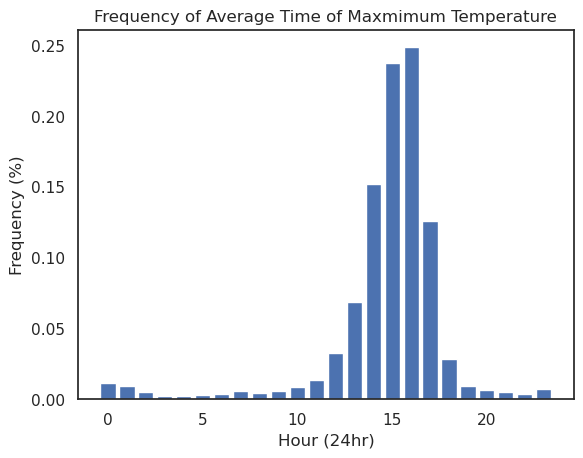

In [77]:
query = """
With MaxTempTimes AS (
        WITH RankedTemp AS (
            SELECT DATE(DateTime) as Date, TIME(DateTime) as Time, 
                Temperature, RANK() OVER (PARTITION BY DATE(DateTime) ORDER BY Temperature DESC) as Rank
            FROM SEA_weather
        )
        SELECT Date, TIME(AVG((STRFTIME('%H', Time) * 60 + STRFTIME('%M', Time)) * 60), 'unixepoch') AS AvgTime
        FROM RankedTemp
        WHERE Rank = 1
        GROUP BY Date
)
SELECT CAST(COUNT(Date) as DOUBLE) / (SELECT COUNT(*) FROM MaxTempTimes) as Freq, CAST(STRFTIME('%H', AvgTime) AS INT) as Hour
FROM MaxTempTimes
GROUP BY Hour
"""

max_temps = pd.read_sql_query(query, connection)
display(max_temps)
plt.bar(max_temps['Hour'].values, max_temps['Freq'].values)
plt.xlabel("Hour (24hr)");
plt.ylabel("Frequency (%)");
plt.title("Frequency of Average Time of Maxmimum Temperature");

Indeed we can see that the maximum temperature of the day occurs most frequently around 3pm.

This phenomenon is most prevalent in the summer, when maximum temperatures are hot enough that you _feel_ when it's the hottest part of the day. I decided to redo this analysis going back and selecting specifically the summer months of June, July, and August. I did this by modifying the innermost query where we rank the temperatures to select only those months.

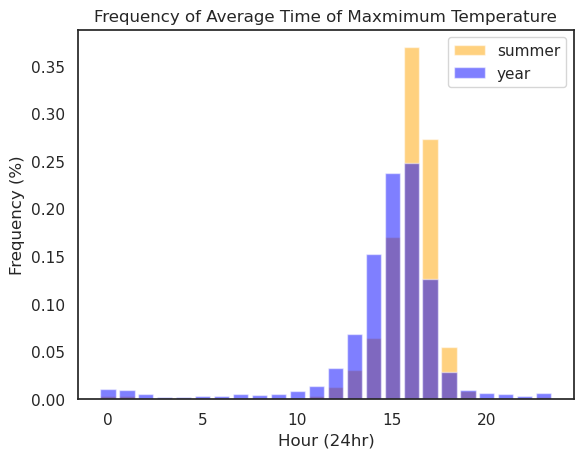

In [85]:
query = """
With MaxTempTimes AS (
        WITH RankedTemp AS (
            SELECT DATE(DateTime) as Date, TIME(DateTime) as Time, 
                Temperature, RANK() OVER (PARTITION BY DATE(DateTime) ORDER BY Temperature DESC) as Rank
            FROM SEA_weather
            WHERE CAST(STRFTIME('%m', DATE(DateTime)) AS INT) IN (6, 7, 8)
        )
        SELECT Date, TIME(AVG((STRFTIME('%H', Time) * 60 + STRFTIME('%M', Time)) * 60), 'unixepoch') AS AvgTime
        FROM RankedTemp
        WHERE Rank = 1
        GROUP BY Date
)
SELECT CAST(COUNT(Date) as DOUBLE) / (SELECT COUNT(*) FROM MaxTempTimes) as Freq, CAST(STRFTIME('%H', AvgTime) AS INT) as Hour
FROM MaxTempTimes
GROUP BY Hour
"""

max_temps_summer = pd.read_sql_query(query, connection)
plt.bar(max_temps_summer['Hour'].values, max_temps_summer['Freq'].values, label='summer', color='orange', alpha=0.5);
plt.bar(max_temps['Hour'].values, max_temps['Freq'].values, label='year', color='blue', alpha=0.5)
plt.legend();
plt.title("Frequency of Average Time of Maxmimum Temperature")
plt.xlabel("Hour (24hr)")
plt.ylabel("Frequency (%)");

So indeed the maximum temperature occurs later more frequently in summer.

### Smoke
In the past few years, wildfires have become fiercer and more prevalent. During the summer now it is not uncommon for smoke to blow in from Eastern Washington or Canada and blanket the city in a smog. It wasn't always like this, however. With the weather data we can count the number of days each year in which the SeaTac weather station observed 'Smoke' as the condition.

First we create a table **TotalSmokeDays** by selecting the dates during which a 'Smoke' condition measurement was made. From this table, we can can group by year and then count the number of days to get the number of smoky days per year.

In [ ]:
query = """
WITH TotalSmokeDays AS (
        SELECT DATE(DateTime) as Date
        FROM Sea_weather
        WHERE Condition='Smoke'
        GROUP BY Date
)
SELECT STRFTIME('%Y', Date) as Year, COUNT(Date) as NumDays
FROM TotalSmokeDays
GROUP BY STRFTIME('%Y', Date)
"""

smoke_days = pd.read_sql_query(query, connection)
display(smoke_days)

,Year,NumDays
0,2015,2
1,2017,12
2,2018,11
3,2020,10
4,2021,3
5,2022,18
6,2023,2


However, since some years didn't have any smoke, they don't appear in the table. For completeness, I decided to create a table that has all the years for which measurements were taken, and then join the two so that any years that didn't have any smoke have a '0' present for their value.

In [ ]:
query = """
WITH NumSmokeDays AS (
        WITH TotalSmokeDays AS (
                SELECT DATE(DateTime) as Date
                FROM Sea_weather
                WHERE Condition='Smoke'
                GROUP BY Date
        )
        SELECT STRFTIME('%Y', Date) as Year, COUNT(Date) as NumDays
        FROM TotalSmokeDays
        GROUP BY STRFTIME('%Y', Date)
),
Years AS (
        SELECT DISTINCT STRFTIME('%Y', Sea_weather.DateTime) as Year
        FROM SEA_weather
)
SELECT Years.Year, IFNULL(NumSmokeDays.NumDays, 0) as NumDays
FROM Years
LEFT OUTER JOIN NumSmokeDays ON Years.Year = NumSmokeDays.Year
"""

smoke_days = pd.read_sql_query(query, connection)
display(smoke_days)

,Year,NumDays
0,2010,0
1,2011,0
2,2012,0
3,2013,0
4,2014,0
5,2015,2
6,2016,0
7,2017,12
8,2018,11
9,2019,0


Then we can plot this smoke data using a bar chart.

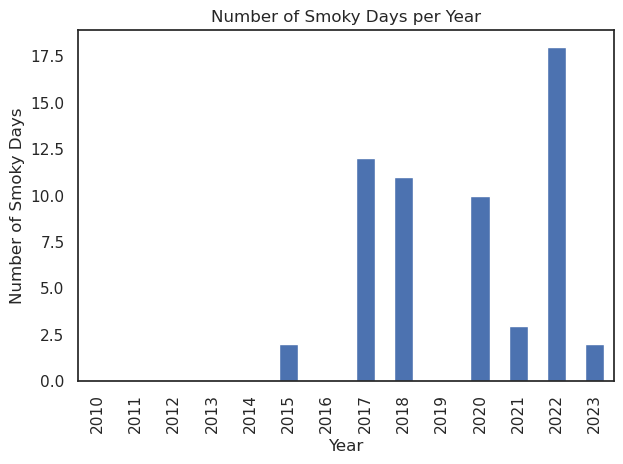

In [ ]:
smoke_days.plot(x="Year", kind="bar", legend=False);
plt.title("Number of Smoky Days per Year")
plt.xlabel("Year")
plt.ylabel("Number of Smoky Days")
plt.tight_layout()

So smoky weather wasn't common before around 2017, but since then it has come almost every year for some duration.

### Rainy days

Seattle is known for being a rainy city. An interesting question is how many rainy days per year Seattle experiences. To do this, we first need a classification system for rain. The NCHM has a "Rainfall Classification" chart to classify rainfall intesity by total millimeters of rainfall per day, found here https://www.nchm.gov.bt/attachment/ckfinder/userfiles/files/Rainfall%20intensity%20classification.pdf.
Using this as the scale, we can classify the intesity of rain for each day in the dataset.

A simplifying assumption that we make here is that *all* precipitation is rain, so that we can simply sum the total precipitation each day. Since Seattle doesn't experience much snow, sleet, or hail, this isn't likely to impact the results too much.

First we need to convert units. The dataset records precipitation amount in inches, so we convert inches to millimeters and save the resulting table as **DailyPrecip_MM**. Then we select the total amount of precipitation, and classify it accordint to the NCHM scale using a **CASE** statement.

,NumDays,RainIntensity
0,101,Heavy Rain
1,750,Light Rain
2,377,Moderate Rain
3,3872,No Rain
4,12,Very Heavy Rain


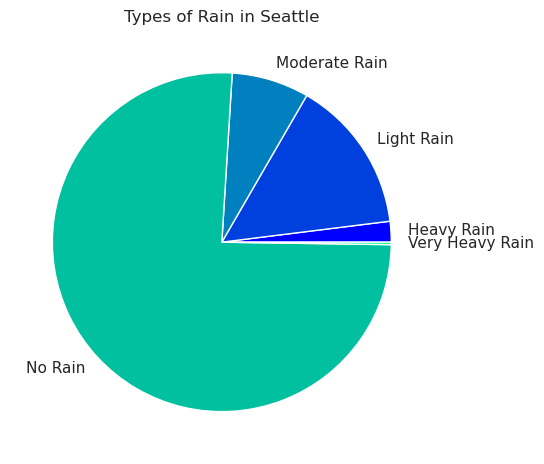

In [ ]:
# Create a query to classify each day by the total rainfall in mm and sum by rainfall category.

query = """
WITH DailyPrecip_MM AS (
        SELECT DATE(DateTime) as Date, SUM(Precip * 25.4) as TotalPrecip_mm
        FROM SEA_weather
        GROUP BY Date
)
SELECT COUNT(Date) as NumDays, CASE
        WHEN TotalPrecip_mm = 0.0 THEN 'No Rain'
        WHEN TotalPrecip_mm >= 0.1 AND TotalPrecip_mm < 1.0 THEN 'Very Light Rain'
        WHEN TotalPrecip_mm >= 1.0 AND TotalPrecip_mm < 11.0 THEN 'Light Rain'
        WHEN TotalPrecip_mm >= 11.0 AND TotalPrecip_mm < 31.0 THEN 'Moderate Rain'
        WHEN TotalPrecip_mm >= 31.0 AND TotalPrecip_mm < 71.0 THEN 'Heavy Rain'
        WHEN TotalPrecip_mm >= 71.0 AND TotalPrecip_mm < 151.0 THEN 'Very Heavy Rain'
        WHEN TotalPrecip_mm >= 151.0 THEN 'Extremely Heavy Rain'
        ELSE 'NULL'
END AS RainIntensity
FROM DailyPrecip_MM
GROUP BY RainIntensity
"""

rain_table = pd.read_sql_query(query, connection)
display(rain_table)
rain_table.plot(kind="pie", y="NumDays", labels=rain_table["RainIntensity"], legend=False, ylabel="", cmap=plt.cm.winter);
plt.title("Types of Rain in Seattle");
plt.tight_layout()

From this we can see that Seattle experiences rain about 25% of the time.

### Cloudy days

The amount of rain doesn't say anything about cloud cover, however. Seattle is grey and gloomy for much of the year, but just *how* much?
To answer this question we need to define a metric for what counts as a cloudy day. On a cloudy day, you don't see the sun for any significant period. Additionally, we are only concerned with daylight hours. If the night is clear, but clouds roll in at 8am and stay for the rest of the day, we consider that day to be cloudy.

Let us first examine all the types of weather that appear in the dataset.

In [ ]:
query = """
SELECT DISTINCT(Condition)
FROM Sea_weather
"""

conditions = pd.read_sql_query(query, connection) 
display(conditions)

,Condition
0,Cloudy
1,Partly Cloudy
2,Mostly Cloudy
3,Mostly Cloudy / Windy
4,Cloudy / Windy
5,Fair
6,Fair / Windy
7,Partly Cloudy / Windy
8,Light Rain
9,Light Drizzle


Any type of precipitation comes with clouds, so we include all those fields. The only condition values that that possibly don't include (many) clouds would be Showers in the Vicinity, None, Mist, Thunder in the Vicinity, Smoke, Shallow Fog, Patches of Fog, Fog, Haze, Fair, Fair / Windy, Partly Cloudy / Windy, and Partly Cloudy. We then define a cloudy day to be any day in which most of the measurements taken for that day are not one of the preceeding weathers.

Further, let us arbitrarly choose our daylight condition to consider the hours between 6am and 8pm. For a more accurate result, we would need to join this table with one that tracks sunrise and sunset times for each day in our dataset, which is not currently avaliable. We will consider a cloudy day to require **12** out of these hours to have cloudy condition measurements.

Let's begin by filtering out all measurements that fall under the "non cloudy weather" category and those that are not in our specified hour range.

In [ ]:
query = """
SELECT Condition, CAST(STRFTIME('%H', DateTime) AS INT) as Hour
FROM Sea_weather
WHERE Hour >= 6 AND Hour <= 20
"""

clouds = pd.read_sql_query(query, connection) 
display(clouds)

,Condition,Hour
0,Cloudy,6
1,Cloudy,7
2,Cloudy,8
3,Cloudy,9
4,Cloudy,10
...,...,...
94727,Mostly Cloudy,16
94728,Mostly Cloudy,17
94729,Mostly Cloudy,18
94730,Mostly Cloudy,19


Now let's remove all the rows where the weather is not in one of the designated categories

In [ ]:
query = """
SELECT Condition, CAST(STRFTIME('%H', DateTime) AS INT) as Hour, DATE(DateTime) as Date
FROM Sea_weather
WHERE Hour >= 6 AND Hour <= 20 AND Condition NOT IN ('Showers in the Vicinity', 'None', 'Mist', 'Thunder in the Vicinity', 
    'Smoke', 'Shallow Fog', 'Patches of Fog', 'Fog', 'Haze', 'Fair', 'Fair / Windy', 'Partly Cloudy / Windy', 'Partly Cloudy')
"""

clouds = pd.read_sql_query(query, connection) 
display(clouds)

,Condition,Hour,Date
0,Cloudy,6,2010-01-01
1,Cloudy,7,2010-01-01
2,Cloudy,8,2010-01-01
3,Cloudy,9,2010-01-01
4,Cloudy,10,2010-01-01
...,...,...,...
67877,Mostly Cloudy,16,2023-12-31
67878,Mostly Cloudy,17,2023-12-31
67879,Mostly Cloudy,18,2023-12-31
67880,Mostly Cloudy,19,2023-12-31


Now let's select the days where the number of unique hour entries is greater than or equal to 12.

In [ ]:
query = """
WITH CloudyEntries AS (
    SELECT Condition, CAST(STRFTIME('%H', DateTime) AS INT) as Hour, DATE(DateTime) as Date
    FROM Sea_weather
    WHERE Hour >= 6 AND Hour <= 20 AND Condition NOT IN ('Showers in the Vicinity', 'None', 'Mist', 'Thunder in the Vicinity', 
        'Smoke', 'Shallow Fog', 'Patches of Fog', 'Fog', 'Haze', 'Fair', 'Fair / Windy', 'Partly Cloudy / Windy', 'Partly Cloudy')
)
SELECT Date
FROM CloudyEntries
GROUP BY Date
HAVING COUNT(DISTINCT(Hour)) >= 12
"""

clouds = pd.read_sql_query(query, connection) 
display(clouds)

,Date
0,2010-01-01
1,2010-01-02
2,2010-01-03
3,2010-01-04
4,2010-01-05
...,...
2903,2023-12-27
2904,2023-12-28
2905,2023-12-29
2906,2023-12-30


Now we have a list of all the days that classify as "cloudy" by our metric. Let's now group by year and sum for cloudy days per year, and then divide by 365 to get percent of year that is cloudy. (There are leap days in this dataset, but for now we ignore them.)

,Year,PercentCloudy
0,2010,62.465753
1,2011,64.383562
2,2012,63.561644
3,2013,58.082192
4,2014,57.534247
5,2015,49.589041
6,2016,60.547945
7,2017,56.164384
8,2018,55.616438
9,2019,56.986301


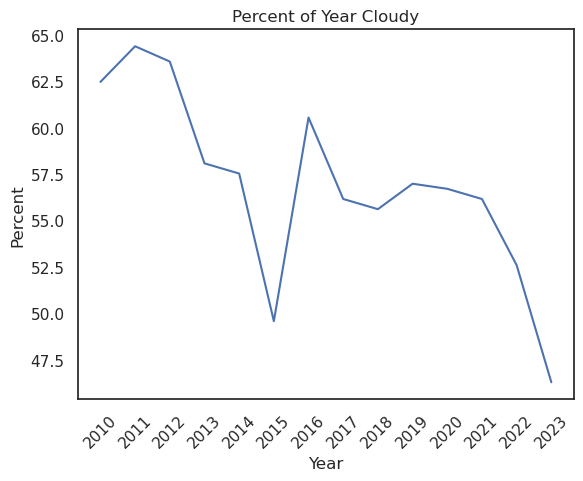

In [86]:
query = """
WITH CloudyDays AS (
    WITH CloudyEntries AS (
        SELECT Condition, CAST(STRFTIME('%H', DateTime) AS INT) as Hour, DATE(DateTime) as Date
        FROM Sea_weather
        WHERE Hour >= 6 AND Hour <= 20 AND Condition NOT IN ('Showers in the Vicinity', 'None', 'Mist', 'Thunder in the Vicinity', 
            'Smoke', 'Shallow Fog', 'Patches of Fog', 'Fog', 'Haze', 'Fair', 'Fair / Windy', 'Partly Cloudy / Windy', 'Partly Cloudy')
    )
    SELECT Date, STRFTIME('%Y', Date) as Year
    FROM CloudyEntries
    GROUP BY Date
    HAVING COUNT(DISTINCT(Hour)) >= 12
)
SELECT Year, CAST(COUNT(Date)AS DOUBLE) / 365 * 100  as PercentCloudy
FROM CloudyDays
GROUP BY Year
"""

clouds = pd.read_sql_query(query, connection) 
display(clouds)
clouds.plot(legend=False)
plt.xticks(clouds.index,clouds["Year"].values, rotation=45)
plt.xlabel("Year")
plt.ylabel("Percent")
plt.title("Percent of Year Cloudy");

We can see that seattle spends about half the year cloudy, and there has been a trend in recent years that the number of cloudy days is going down.